# DAML notes
## 9. Gaussian processes (GPs)

<hr style="border:2px solid black"> </hr>


In [1]:
# RUN THIS CELL FIRST

# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# Better plots
plt.rcParams.update(
    {
        "lines.markersize": 10,  # Big points
        "font.size": 15,  # Larger font
        "savefig.dpi": 300,  # Higher res output
        "savefig.format": "pdf",  # PDF outputs
        "savefig.bbox": "tight",  # remove whitespace around figure
        "savefig.transparent": True,  # transparent background
        "xtick.major.size": 5.0,  # Bigger xticks
        "ytick.major.size": 5.0,  # Bigger yticks
    }
)

### 9.1 Continuous random variables and the Gaussian distribution

Consider some real-valued quantity $X\in\mathbb{R}$ that we care about, but when we try to measure it there is noise and we get different values each time. We have an idea about what it *should be* (e.g. the mean of our measurements) but we want to be able to express our degree of uncertainty (e.g. through the standard deviation of our measurements).

We can achieve this by treating $X$ as a continous random variable, and represent it by its probability density function $p(X=x)$, which we will write as $p(x)$ for short.

>Here $X$ is a random variable, and $x$ is a realisation of that random variable. It is fairly likely I will be a bit sloppy with my notation with respect to these (while protesting that I am no mathematician). The main purpose of the maths you see is to aid understanding, so if it achieves that then I will be happy enough.




Integrating $p(x)$ between two points gives the probability that a measurement of $X$ will lie between those values:

\begin{equation} \mathrm     {P}(a < X\leq b) = \int_{a}^{b} p(x) \,dx \end{equation}

It follows that $\int_{-\infty }^{\infty } p(x) \,dx=1$.

The mean and variance of $X$ can be computed from this pdf:

\begin{equation}\mathbb{E}[X]= \int_{-\infty}^\infty x p(x) dx=\mu\end{equation}



\begin{equation} \mathbb{E}[(X-\mu)^2]=\mathbb{V}[X]= \int_{-\infty}^\infty (x-\mu)^2 p(x) dx=\sigma^2\end{equation}

It is very common to default to a Gaussian pdf for a continuous random variable

\begin{equation}p(x) = \mathcal{N}(x ; \mu,\,\sigma^{2})=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(x-\mu)^2} \end{equation}

We can write this more succinctly as $X\sim  \mathcal{N}( \mu,\,\sigma^{2})$. There are several reasons why Gaussians are commonly used:

- They are easy to interpret, being defined entirely by their mean (the peak) and their variance (the spread) 
- They are mathematically convienient, being closed under marginalisation and conditioning (see later)
- The central limit theorem tell us that the sum of (lots of) random variables is approximately Gaussian 

While we are not going to go into the details, it's important to appreciate that you can **sample** from a pdf. 

The code below plots a Gaussian pdf. You can change $\mu$ and $\sigma$ to see how it affects the plot.

Text(0, 0.5, '$p(x)$')

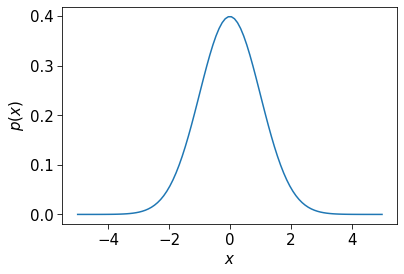

In [2]:
sigma = 1
mu = 0


def gauss(x, mu, sigma):
    return (
        1
        / (np.sqrt(2 * np.pi * sigma**2))
        * np.exp(-((1) / (2 * sigma**2)) * (x - mu) ** 2)
    )


x = np.linspace(-5, 5, 100)
px = gauss(x, mu, sigma)

fig, ax = plt.subplots()
ax.plot(x, px)
ax.set_xlabel("$x$")
ax.set_ylabel("$p(x)$")

### 9.2 Joint pdfs and the Bivariate Gaussian

Often we have random variables that are related to each other. If we have two such random variables $X_1$ and $X_2$, we can consider their joint pdf $p(x_1,x_2)$. From this, we can recover the individual distributions through **marginalisation**.

\begin{equation}
p(x_1) =  \int_{-\infty }^{\infty } p(x_1,x_2) \,dx_2
\end{equation}

\begin{equation}
p(x_2) =  \int_{-\infty }^{\infty } p(x_1,x_2) \,dx_1
\end{equation}

We can also do **conditioning**. For instance, if we find out the exact value of $X_1$ is $x_1$, we can look at the conditional distribution for $X_2$ given this information $p(x_2|X_1=x_1)$. For brevity, I will write this as $p(x_2|x_1)$. This can be obtained from Bayes' rule:

\begin{equation}
p(x_2|x_1) = \frac{p(x_1,x_2)}{p(x_1)}=\frac{p(x_1,x_2)}{\int_{-\infty }^{\infty } p(x_1,x_2) \,dx_2}
\end{equation}

This looks different to how Bayes' rule is usually represented, but recall that the numerator $p(x_1,x_2)=p(x_1|x_2)p(x_2)$.

The most common joint pdf (and the one we will default to) is the Multivariate Gaussian. For some  vector of $D$ random variables $\mathbf{x}=\begin{bmatrix}X_1,X_2,\dots,X_D\end{bmatrix}^\top$, this is given by

\begin{equation} p(\mathbf{x})=  \mathcal{N}(\mathbf{x};\boldsymbol\mu,\,\boldsymbol\Sigma)= \frac{1}{(2\pi)^{D/2}|\boldsymbol\Sigma|^{1/2}}\exp\Bigr[-\frac{1}{2}(\mathbf{x}-\boldsymbol\mu)^\top \boldsymbol\Sigma^{-1}(\mathbf{x}-\boldsymbol\mu)\Bigr]\end{equation}




In the case of two random variables ($\mathbf{x}=\begin{bmatrix}X_1,X_2\end{bmatrix}^\top$) this is referred to as a Bivariate Gaussian and $p(x_1,x_2 ) = \mathcal{N}(x_1,x_2;\boldsymbol\mu ,\boldsymbol\Sigma)$ where $\boldsymbol\mu = \begin{bmatrix}\mu_1 \\ \mu_2 \end{bmatrix}$ and $\boldsymbol\Sigma=\begin{bmatrix}\sigma_{1,1} & \sigma_{1,2}\\\sigma_{2,1} & \sigma_{2,2}\\\end{bmatrix}$.

 
We can also write this as

\begin{equation}\begin{bmatrix}x_1 \\ x_2\end{bmatrix} \sim \mathcal{N}\biggl( 
\begin{bmatrix}\mu_1 \\ \mu_2 \end{bmatrix},\, \begin{bmatrix}
\sigma_{1,1} & \sigma_{1,2}\\
\sigma_{2,1} & \sigma_{2,2}\\
\end{bmatrix}\biggl)\end{equation}

Here, the covariance $\sigma_{i,j}=\mathbb{E}\Bigr[ (X_i - \mathbb{E}[X_i])(X_j - \mathbb{E}[X_j])\Bigr]$. I am using this to represent both variances ($i=j$) and covariances $(i \neq j)$.

> Writing the Bivariate Gaussian distribution without vectors and matrices is painful, which is why I started with the definition of a Multivariate Gaussian :)

I mentioned earlier that an advantage of working with Gaussians is that they are closed under marginalisation and conditioning. What this means is that the marginal distributions and conditional distributions are also Gaussian. This is mathematically very convenient. 

To marginalise a Bivariate Gaussian, we just pick out the corresponding mean and variance:

\begin{equation} p(x_1)=  \mathcal{N}(x_1;\mu_1 \,\sigma_{1,1})\end{equation}

\begin{equation} p(x_2)=  \mathcal{N}(x_1;\mu_2 \,\sigma_{2,2})\end{equation}

The conditional distribution $p(x_2|x_1)$  (given without proof) is:

\begin{equation}p(x_2|x_1)=  \mathcal{N}(x_2;\mu_2 +\frac{\sigma_{1,2}}{\sigma_{1,1}}(x_1 -\mu_1 ) ,\sigma_{2,2 }-\frac{\sigma_{1,2}^2}{\sigma_{1,1}})\end{equation}

### 9.3 The Multivariate Gaussian

Let's now consider the more general multivariate case. If we have a vector of random variables $\mathbf{x}=\begin{bmatrix}X_1,X_2,\dots,X_D\end{bmatrix}^\top$ that are jointly Gaussian then 

\begin{equation} p(\mathbf{x})=  \mathcal{N}(\mathbf{x};\boldsymbol\mu,\,\boldsymbol\Sigma)= \frac{1}{(2\pi)^{D/2}|\boldsymbol\Sigma|^{1/2}}\exp\Bigr[-\frac{1}{2}(\mathbf{x}-\boldsymbol\mu)^\top \boldsymbol\Sigma^{-1}(\mathbf{x}-\boldsymbol\mu)\Bigr]\end{equation}

where $\boldsymbol\mu = \begin{bmatrix}\mu_1 \\ \mu_2 \\ \vdots \\ \mu_{D}\end{bmatrix}$ and $\boldsymbol\Sigma = \begin{bmatrix}
\sigma_{1,1} & \sigma_{1,2}&\dots&\sigma_{1,D}\\
\sigma_{2,1} & \sigma_{2,2} &\dots & \sigma_{2,D}\\
\vdots&\vdots&\ddots&\vdots\\
\sigma_{D,1} & \sigma_{D,2} &\dots & \sigma_{D,D}\\
\end{bmatrix}$.

Marginalising is very straightforward. As with the Bivariate case, we pick out the corresponding mean and variance for a variable.

\begin{equation}p(x_i)=  \mathcal{N}(x_i;\mu_i \,\sigma_{i,i})\end{equation}

Conditioning is slightly more involved because we can condition the distribution for some random vector on another and both can be a variety of sizes. To write a general expression for conditioning, we partition $\mathbf{x}$ as $\mathbf{x}=\begin{bmatrix}\mathbf{x}_1,\mathbf{x}_2\end{bmatrix}^\top$ where $\mathbf{x}_1\in \mathbb{R}^{D_1}$ and $\mathbf{x}_2\in \mathbb{R}^{D_2}$ (therefore $D_1 + D_2$ must equal $D$). After making this partition, we can write 

\begin{equation}\begin{bmatrix}\mathbf{x}_1 \\ \mathbf{x}_2\end{bmatrix}\sim \mathcal{N}(\begin{bmatrix}\boldsymbol\mu_1 \\ \boldsymbol\mu_2\end{bmatrix},\,\begin{bmatrix}\boldsymbol\Sigma_{1,1} &\boldsymbol\Sigma_{2,1}\\ \boldsymbol\Sigma_{1,2} & \boldsymbol\Sigma_{2,2} \end{bmatrix})
\end{equation}

> All we've done here is split the mean vector in two, and the covariance matrix into four. Imagine that $\mathbf{x}\in\mathbb{R}^5$ and we had $D_1=2$ and $D_2=3$. $\boldsymbol\mu_1$ would be the top two elements of the mean vector, and $\boldsymbol\mu_2$ would be the bottom three elements. $\boldsymbol\Sigma_{1,1}$ would be the top-left $2\times2$ submatrix of $\boldsymbol\Sigma$. $\boldsymbol\Sigma_{1,2}$ would be the top-right $2\times3$ submatrix. $\boldsymbol\Sigma_{2,1}$ would be the bottom-left $3\times2$ submatrix. $\boldsymbol\Sigma_{2,2}$ would be the bottom-right $3\times3$ submatrix.

If we find out the exact values for the elements in $\mathbf{x}_1$ then we can compute the condition distribution $p(\mathbf{x}_2 | \mathbf{x}_1)$. Without proof, this is given by:

\begin{equation}p(\mathbf{x}_2 | \mathbf{x}_1) = \mathcal{N}(\mathbf{x}_2;\boldsymbol\mu_{2|1},\boldsymbol\Sigma_{2|1})\end{equation}

where

\begin{equation} \boldsymbol\mu_{2|1} = \boldsymbol\mu_2 + \boldsymbol\Sigma_{2,1}\boldsymbol\Sigma_{1,1}^{-1}(\mathbf{x}_1-\boldsymbol\mu_1)\end{equation}

\begin{equation} \boldsymbol\Sigma_{2|1} = \boldsymbol\Sigma_{2,2}- \boldsymbol\Sigma_{2,1}\boldsymbol\Sigma_{1,1}^{-1}\boldsymbol\Sigma_{1,2}\end{equation}

We now have everything we need to look at Gaussian processes. They are basically just a great big Multivariate Gaussian!

### 9.4 A Gaussian Process model

For regression problems, we try and find a model $f(\mathbf{x}$) that best maps data points $\mathbf{x}\in\mathbb{R}^D$ to targets $y\in\mathbb{R}$. 

Implicitly, $f(\mathbf{x})$ is our model of some underlying, unknown function. We are going to introduce Gaussian processes in the context of modelling an unknown function and tie it to regression later in.

We will denote a Gaussian process model using

\begin{equation}f(\mathbf{x}) \sim GP(m(\mathbf{x}),k(\mathbf{x},\mathbf{x}')) \end{equation}

It is defined entirely in terms of its mean function $m(\mathbf{x})$ and kernel function $k(\mathbf{x},\mathbf{x}')$, which we will return to shortly.

For **any** (non-zero) set of input points $\mathbf{X}= \begin{bmatrix}\mathbf{x}^{(1)},\mathbf{x}^{(2)},\dots ,\mathbf{x}^{(M)}\end{bmatrix}^\top$, the function values $\mathbf{f}=\begin{bmatrix}f(\mathbf{x}^{(1)}),f(\mathbf{x}^{(2)}),\dots ,f(\mathbf{x}^{(M)})\end{bmatrix}^\top$ are treated as **random variables** that have a **Multivariate Gaussian distribution**

\begin{equation}
\mathbf{f}\sim \mathcal{N}(\boldsymbol\mu, \boldsymbol \Sigma  ) \end{equation}

$\boldsymbol\mu$ is determined by the mean function $\boldsymbol\mu= [m(\mathbf{x}^{(1)}),m(\mathbf{x}^{(2)}),\dots, m(\mathbf{x}^{(M)})]^\top$ and $\boldsymbol\Sigma$ is determined by the kernel function in that $\boldsymbol \Sigma_{i,j} =k(\mathbf{x}^{(i)},\mathbf{x}^{(j)})$. In full, we can write

\begin{equation}
\begin{bmatrix}f(\mathbf{x}^{(1)})\\f(\mathbf{x}^{(2)})\\ \vdots \\ f(\mathbf{x}^{(M)})\end{bmatrix}
 \sim \mathcal{N} \Biggl(
\begin{bmatrix}
m(\mathbf{x}^{(1)})\\ m(\mathbf{x}^{(2)}) \\ \vdots\\ m(\mathbf{x}^{(M)})\end{bmatrix}
,\,
 \begin{bmatrix}
k(\mathbf{x}^{(1)},\mathbf{x}^{(1)}) & k(\mathbf{x}^{(1)},\mathbf{x}^{(2)})&\dots&k(\mathbf{x}^{(1)},\mathbf{x}^{(M)})\\
k(\mathbf{x}^{(2)},\mathbf{x}^{(1)})& k(\mathbf{x}^{(2)},\mathbf{x}^{(2)}) &\dots & k(\mathbf{x}^{(2)},\mathbf{x}^{(M)})\\
\vdots&\vdots&\ddots&\vdots\\
k(\mathbf{x}^{(M)},\mathbf{x}^{(1)}) & k(\mathbf{x}^{(M)},\mathbf{x}^{(2)}) &\dots & k(\mathbf{x}^{(M)},\mathbf{x}^{(M)})\\
\end{bmatrix}
 \Biggl)\end{equation}
 
**Please stare at this equation until you understand it!**

Typically, we use a zero mean function ($m(\mathbf{x})=0$) and we will assume that this is always the case on this course. The generalisation properties of the GP are largely determined by its kernel function.

Given two input points $\mathbf{x}$ and $\mathbf{x}'$, the kernel tells us what the covariance between their function values $f(\mathbf{x})$ and $f(\mathbf{x}')$ is. Recall that for a GP model, all function values are treated as random variables.

The default kernel (in sklearn and in general) is the radial basis function (RBF) (or squared exponential) kernel:

\begin{equation} k_{SE}(\mathbf{x},\mathbf{x}') = \exp\biggl(  -\frac{\lVert 
\mathbf{x}-\mathbf{x}'\lVert ^2}{2\ell^2 }\biggl)\end{equation}

Here, $\ell$ is a hyperparameter known as the lengthscale, which we will set to 1 for now.

Let's plot this kernel as a function of $d=\lVert 
\mathbf{x}-\mathbf{x}'\lVert$:

Text(0, 0.5, '$k_{SE}(d)$')

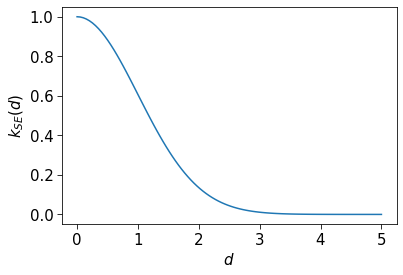

In [3]:
d = np.linspace(0, 5, 100)
k = np.exp(-(d**2) / 2)
fig, ax = plt.subplots(figsize=[6, 4])
ax.plot(d, k)
ax.set_xlabel("$d$")
ax.set_ylabel("$k_{SE}(d)$")

We can see that when the distance between two input points is low, the covariance (and therefore correlation) between their function values is high, and that when the distance between two input points is high, the correlation between their function values is low. This is quite intuitive if you think about house prices (an example I heard in an online lecture years ago). Imagine that you are modelling the relationship between the location of a house (longitude, latitude) and its price. Houses that are close together will have correlated house prices, whereas houses far away from each other will not.

### 9.5 Gaussian process prior

A GP that has not been *fit* to training data is referred to as a GP prior. By providing a mean and kernel function we have baked in our apriori assumptions about what the function we are trying to model should look like. 

We are going to consider the 1D input case $x\in\mathbb{R}$ where we have a GP prior

\begin{equation}f(x) \sim GP(0,\exp\biggl(  -\frac{\lVert 
x-x'\lVert ^2}{2 }\biggl)) \end{equation}

We can sample possible functions from the prior by creating some closely-spaced dummy points $\mathbf{X}_\ast= \begin{bmatrix}{x}_\ast^{(1)},{x}_\ast^{(2)},\dots ,{x}_\ast^{(M)}\end{bmatrix}^\top$ and then sampling realisations of $\mathbf{f_\ast}=\begin{bmatrix}f({x_\ast}^{(1)}),f({x_\ast}^{(2)}),\dots ,f({x_\ast}^{(M)})\end{bmatrix}^\top$ from 

\begin{equation}
\begin{bmatrix}f({x}^{(1)})\\f({x}^{(2)})\\ \vdots \\ f({x}^{(M)})\end{bmatrix}
 \sim \mathcal{N} \Biggl(
\begin{bmatrix}
0\\ 0 \\ \vdots\\ 0\end{bmatrix}
,\,
\begin{bmatrix}
k(x^{(1)}_\ast, x^{(1)}_\ast) & k(x^{(1)}_\ast, x^{(2)}_\ast) & \dots & k(x^{(1)}_\ast, x^{(M)}_\ast)\\
k(x^{(2)}_\ast, x^{(1)}_\ast) & k(x^{(2)}_\ast, x^{(2)}_\ast) & \dots & k(x^{(2)}_\ast, x^{(M)}_\ast)\\
\vdots & \vdots & \ddots & \vdots\\
k(x^{(M)}_\ast, x^{(1)}_\ast) & k(x^{(M)}_\ast, x^{(2)}_\ast) & \dots & k(x^{(M)}_\ast, x^{(M)}_\ast)\\
\end{bmatrix}
 \Biggl)\end{equation}
 
We can write the above concisely as $\mathbf{f}_\ast \sim \mathcal{N}(\mathbf{0},\boldsymbol\Sigma_{\mathbf{X}_\ast,\mathbf{X}_\ast})$.

Let's do this in sklearn:

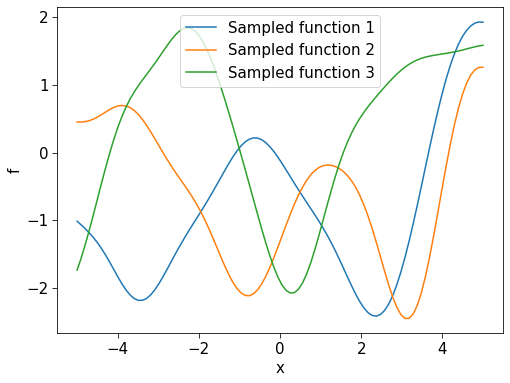

In [4]:
# Create a Gaussian process that will default to zero mean and RBF kernel
# Ignore alpha for now
gp = GaussianProcessRegressor(alpha=0)

# Create an array of dummy points and reshape into a format sklearn will be happy with
X_star = np.linspace(-5, 5, 100).reshape(-1, 1)

# Sample 3 realisations of f_star (3 possible functions) from the GP prior with different seeds
f_star_0 = gp.sample_y(X_star, random_state=0)
f_star_1 = gp.sample_y(X_star, random_state=1)
f_star_2 = gp.sample_y(X_star, random_state=2)

# Plot these
fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(X_star, f_star_0)
ax.plot(X_star, f_star_1)
ax.plot(X_star, f_star_2)

ax.set_xlabel("x")
ax.set_ylabel("f")
plt.legend(["Sampled function 1", "Sampled function 2", "Sampled function 3"])

The functions are wiggly with peaks and troughs. These are regions where points are close together and have function values are highly correlated, as specified by our kernel.

We can also look at the individual distribution of function values at each of these dummy points. This can be achieved by marginalising the distribution above to get $f({x}^{(1)})\sim \mathcal{N}(0,k(x^{(1)}_\ast, x^{(1)}_\ast)),\,\, f({x}^{(2)})\sim \mathcal{N}(0,k(x^{(2)}_\ast, x^{(2)}_\ast))$ etc. Note that for every one of these marginal distribution the output of the kernel is 1.

To visualise all these marginal distributions at once, we can produce a plot where we draw a curve that goes through the mean function value for each point and where we shade the area that is plus or minus two standard deviations from this mean. The significance of this is that 95% of the time a sample drawn from a Gaussian distribution will lie within this region so it represents our uncertainty.

The code below does this plot for the GP prior. Please note that it is very boring, as every function value has mean 0 and variance 1!

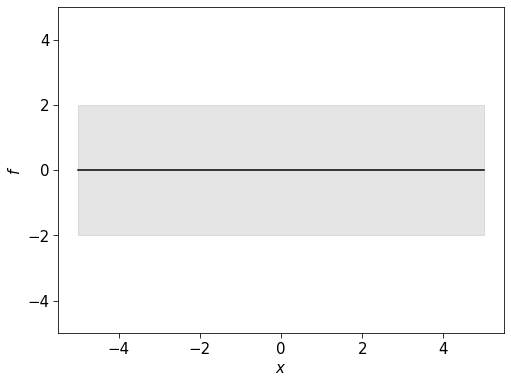

In [5]:
def plot_gp_marginals(X, f_mean, f_std):

    ax.plot(X.flatten(), f_mean, color="black", label="Mean")
    ax.fill_between(
        X.flatten(),
        f_mean - 2 * f_std,
        f_mean + 2 * f_std,
        alpha=0.1,
        color="black",
    )
    ax.set_xlabel("$x$")
    ax.set_ylabel("$f$")
    ax.set_ylim([-5, 5])


prior_means, prior_stds = gp.predict(X_star, return_std=True)

fig, ax = plt.subplots(figsize=[8, 6])
plot_gp_marginals(X_star, prior_means, prior_stds)

### 9.6 Gaussian Process posterior

Recall that when we had our Multivariate Gaussian, we partitioned our random vector into two. We can do the same thing with our GP. Let's split our points into $\mathbf{X}$ and $\mathbf{X_\ast}$ with corresponding function values $\mathbf{f}$ and $\mathbf{f_\ast}$ respectively. Continuing with our zero mean function assumption, we can write

\begin{equation}\begin{bmatrix}\mathbf{f} \\ \mathbf{f_\ast}\end{bmatrix}\sim  \mathcal{N}(\mathbf{0},\,\begin{bmatrix}\boldsymbol\Sigma_{\mathbf{X},\mathbf{X}} &\boldsymbol\Sigma_{\mathbf{X},\mathbf{X_\ast}}\\ \boldsymbol\Sigma_{\mathbf{X_\ast},\mathbf{X}} & \boldsymbol\Sigma_{\mathbf{X_\ast},\mathbf{X_\ast}} \end{bmatrix})\end{equation}

and condition as before:

\begin{equation}p(\mathbf{f_\ast}| \mathbf{f},\mathbf{X},\mathbf{X}_\ast ) = \mathcal{N}(\mathbf{f}_\ast ;\boldsymbol\mu_{\mathbf{X_\ast}|\mathbf{X}},\boldsymbol\Sigma_{\mathbf{X_\ast}|\mathbf{X}})\end{equation}

where 

\begin{equation}\boldsymbol\mu_{\mathbf{X_\ast}|\mathbf{X}} = \boldsymbol\Sigma_{\mathbf{X_\ast},\mathbf{X}}\boldsymbol\Sigma_{\mathbf{X},\mathbf{X}}^{-1}\mathbf{f}\end{equation}

\begin{equation}\boldsymbol\Sigma_{\mathbf{X_\ast}|\mathbf{X}} = \boldsymbol\Sigma_{\mathbf{X_\ast},\mathbf{X_\ast}}- \boldsymbol\Sigma_{\mathbf{X_\ast},\mathbf{X}}\boldsymbol\Sigma_{\mathbf{X},\mathbf{X}}^{-1}\boldsymbol\Sigma_{\mathbf{X},\mathbf{X_\ast}}\end{equation}

These equations are slightly simpler than the conditioning equations from earlier because the prior means are both zero.

We now have everything we need to perform Gaussian process regression. If we have training inputs $\mathbf{X}$ with targets $\mathbf{f}$ and we want to make predictions at points $\mathbf{X}_\ast$ then we just compute $p(\mathbf{f_\ast}| \mathbf{f},\mathbf{X},\mathbf{X}_\ast )$. We refer to $p(\mathbf{f_\ast}| \mathbf{f},\mathbf{X},\mathbf{X}_\ast )$ as our GP posterior. It is the distribution of function values $\mathbf{f_\ast}$ conditioned on our training data.

We can marginalise $p(\mathbf{f_\ast}| \mathbf{f},\mathbf{X},\mathbf{X}_\ast )$ for each individual function value to get a mean and variance (/standard deviation). We can use the mean as our prediction at that point and the standard deviation as a measure of uncertainty. 

We will now fit a Gaussian process to training data (fitting a GP just means computing the posterior $p(\mathbf{f_\ast}| \mathbf{f},\mathbf{X},\mathbf{X}_\ast )$ for fixed hyperparameters) and look at the posterior's marginal distributions. We will use a simple 1D dataset with 3 data points.

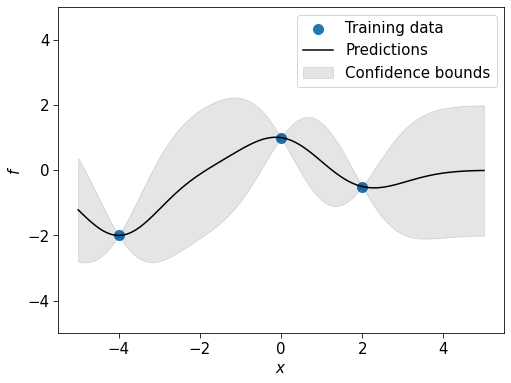

In [6]:
# Training set
X = np.array([-4, 0, 2]).reshape(-1, 1)
y = np.array([-2, 1, -0.5])

# Dummy points we want to evaluate at
X_star = np.linspace(-5, 5, 100).reshape(-1, 1)

# Fit the GP (ignore what alpha is for now)
gp.fit(X, y)

fig, ax = plt.subplots(figsize=[8, 6])


# Plot the training data
ax.scatter(X, y)

# Compute then plot the marginal distributions of the posterior
posterior_means, posterior_stds = gp.predict(X_star, return_std=True)
plot_gp_marginals(X_star, posterior_means, posterior_stds)

plt.legend(["Training data", "Predictions", "Confidence bounds"])

Points near training points have low uncertainty and points further away have higher uncertainty. Getting uncertainty measurements alongside predictions is really nice!

In addition to this "sausage plot", we can sample functions from the GP posterior.

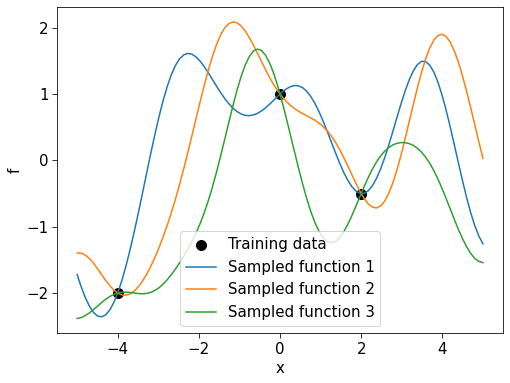

In [7]:
# Plot training data
fig, ax = plt.subplots(figsize=[8, 6])
ax.scatter(X, y, color="k")

# Sample 3 realisations of f_star (3 possible functions) from the GP posterior with different seeds
f_star_0 = gp.sample_y(X_star, random_state=0)
f_star_1 = gp.sample_y(X_star, random_state=1)
f_star_2 = gp.sample_y(X_star, random_state=2)

# Plot these
ax.plot(X_star, f_star_0)
ax.plot(X_star, f_star_1)
ax.plot(X_star, f_star_2)

ax.set_xlabel("x")
ax.set_ylabel("f")
plt.legend(
    ["Training data", "Sampled function 1", "Sampled function 2", "Sampled function 3"]
)

All functions sampled interpolate the training data. This is sensible, except it does not account for noise in the training targets.

### 9.7 Dealing with noisy measurements

Most of the time it is unrealistic to assume that our targets are free of any noise, and it isn't ideal if the functions generated by the GP posterior are forced to pass through a dubious training point. In the example below, most of the data points are drawn from a sine curve but I've added one data point that isn't. Rather than following the nice sine pattern, the GP predictions oscillate wildly to ensure that all the points are interpolated.

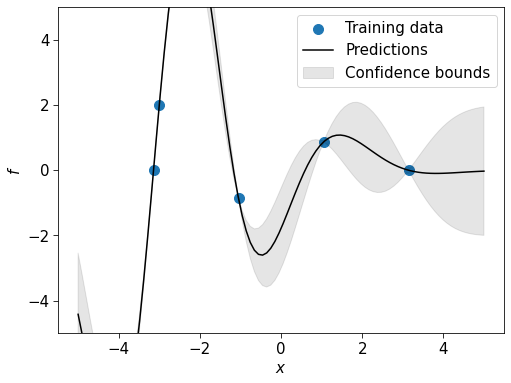

In [8]:
X = np.linspace(-np.pi, np.pi, 4)
y = np.sin(X)

# Add a daft point
X = np.append(X, -3)
y = np.append(y, 2)


# Fit a GP
gp = GaussianProcessRegressor(alpha=0).fit(X.reshape(-1, 1), y)

# Dummy points we want to evaluate at
X_star = np.linspace(-5, 5, 100).reshape(-1, 1)

# Plot
fig, ax = plt.subplots(figsize=[8, 6])
ax.scatter(X, y)
posterior_means, posterior_stds = gp.predict(X_star, return_std=True)
plot_gp_marginals(X_star, posterior_means, posterior_stds)
plt.legend(["Training data", "Predictions", "Confidence bounds"])

We will assume that our targets $\mathbf{y}= \begin{bmatrix}y^{(1)}&y^{(2)}&\dots&y^{(N)}\end{bmatrix}^\top$ suffer from additive Gaussian noise with standard deviation $\sigma_y$. 

This means for some target $y$ we have $y$ = $f(x)+\mathcal{N}(0,\sigma_y)$. For multiple targets $\mathbf{y}= \begin{bmatrix}y^{(1)}&y^{(2)}&\dots&y^{(N)}\end{bmatrix}^\top$ we have $\mathbf{y}\sim\mathcal{N}(\mathbf{0},\boldsymbol\Sigma_{\mathbf{X},\mathbf{X}} +\sigma_{y}^2 \mathbf{I})$.

Instead of writing the joint distribution of $\mathbf{f}$ and $\mathbf{f_\ast}$ as we did in the noise-free case, we can write the joint distribution of $\mathbf{y}$ and $\mathbf{f_\ast}$ (which is very similar):

\begin{equation}\begin{bmatrix}\mathbf{y} \\ \mathbf{f_\ast}\end{bmatrix}\sim  \mathcal{N}(\mathbf{0},\,\begin{bmatrix}\boldsymbol\Sigma_{\mathbf{X},\mathbf{X}}+\sigma_y\mathbf{I}&\boldsymbol\Sigma_{\mathbf{X},\mathbf{X_\ast}}\\ \boldsymbol\Sigma_{\mathbf{X_\ast},\mathbf{X}} & \boldsymbol\Sigma_{\mathbf{X_\ast},\mathbf{X_\ast}} \end{bmatrix})\end{equation}

We can condition to get

\begin{equation}p(\mathbf{f_\ast}| \mathbf{y},\mathbf{X},\mathbf{X}_\ast ) = \mathcal{N}(\mathbf{f}_\ast ;\boldsymbol\mu_{\mathbf{X_\ast}|\mathbf{X}},\boldsymbol\Sigma_{\mathbf{X_\ast}|\mathbf{X}})\end{equation}

where 

\begin{equation}\boldsymbol\mu_{\mathbf{X_\ast}|\mathbf{X}} = \boldsymbol\Sigma_{\mathbf{X_\ast},\mathbf{X}}\boldsymbol(\Sigma_{\mathbf{X},\mathbf{X}}^{-1}+\sigma_y\mathbf{I})\mathbf{y}\end{equation}

\begin{equation}\boldsymbol\Sigma_{\mathbf{X_\ast}|\mathbf{X}} = \boldsymbol\Sigma_{\mathbf{X_\ast},\mathbf{X_\ast}}- \boldsymbol\Sigma_{\mathbf{X_\ast},\mathbf{X}}\boldsymbol(\Sigma_{\mathbf{X},\mathbf{X}}^{-1}+\sigma_y\mathbf{I})\boldsymbol\Sigma_{\mathbf{X},\mathbf{X_\ast}}\end{equation}

$\sigma_y$ is given by the `alpha` argument to the GP in sklearn. Let's redo the plot above but with a moderate $\sigma_y$. 

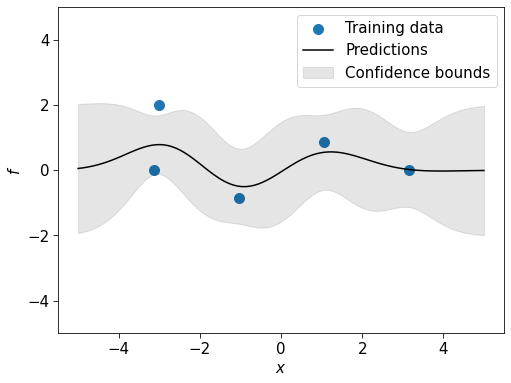

In [9]:
# Fit a GP, assuming there is additive label noise with std 0.5
gp = GaussianProcessRegressor(alpha=0.5).fit(X.reshape(-1, 1), y)

# Dummy points we want to evaluate at
X_star = np.linspace(-5, 5, 100).reshape(-1, 1)

# Plot
fig, ax = plt.subplots(figsize=[8, 6])
ax.scatter(X, y)
posterior_means, posterior_stds = gp.predict(X_star, return_std=True)
plot_gp_marginals(X_star, posterior_means, posterior_stds)
plt.legend(["Training data", "Predictions", "Confidence bounds"])

The prediction curve no longer interpolates the training points and there is now uncertainty even when it lines up with training data.

### 9.8 Optimising kernel hyperparameters

Consider a GP with zero mean function and kernel

\begin{equation} k(\mathbf{x},\mathbf{x}') = \sigma\exp\biggl(  -\frac{\lVert 
\mathbf{x}-\mathbf{x}'\lVert ^2}{2\ell^2 }\biggl)\end{equation}

This is the RBF kernel — which has hyperparameter $\ell$ — scaled by another hyperparameter $\sigma$. Changing these has a significant effect on the functions the GP can produce. 

These hyperparameters can be optimised through e.g. a grid search but a fast alternative is to instead find the hyperparameters that maximise the marginal likelihood of our targets $p(\mathbf{y}|\mathbf{X})$. This is called a *marginal* likelihood because we have marginalised out $\mathbf{f}$

\begin{equation}
p(\mathbf{y}|\mathbf{X}) =  \int p(\mathbf{y}|\mathbf{X}, \mathbf{f}) \,d\mathbf{f}
\end{equation}

We already know that $p(\mathbf{y}|\mathbf{X})=\mathcal{N}(\mathbf{y};\mathbf{0},\boldsymbol\Sigma_{\mathbf{X},\mathbf{X}} +\sigma_{y}^2 \mathbf{I})$ for noisy measurements. The exponential in the normal is annoying, but maximising $p(\mathbf{y}|\mathbf{X})$ is the same as minimising $-\log p(\mathbf{y}|\mathbf{X})$.
\begin{equation}\log  p(\mathbf{y}|\mathbf{X})= -\frac{1}{2}\mathbf{y}^\top (\boldsymbol\Sigma_{\mathbf{X},\mathbf{X}} + \sigma_y ^2 \mathbf{I})^{-1}\mathbf{y} - \frac{1}{2}\log |\boldsymbol\Sigma_{\mathbf{X},\mathbf{X}} + \sigma_y ^2 \mathbf{I}| - \frac{N}{2}\log 2\pi \end{equation}

This can be differentiated with respect to hyperparameters as long as the kernel is differentiable (although I am not going to write out the expression!). This means a gradient based optimiser can be used to solve $\underset{\boldsymbol\theta }{\mathrm{minimise}}\,-\log  p(\mathbf{y}|\mathbf{X})$.

When you call `.fit` for GPs in sklearn, this is done by default. This means that training data is used to optimise these hyperparameters instead of validation data, which is unusual. However, there is [some work](https://arxiv.org/abs/1905.08737) that claims there is an equivalence to cross-validation. There is [also work](https://arxiv.org/abs/2202.11678) claiming that maximising marginal likelihood can harm generalisation! I am not going to claim that maximising marginal likelihood is the correct thing to do, only note that it is what sklearn does and to be aware that alternative approaches may be better. As with a lot of things, it all depends on your data.

Anyway, let's see it in action using a GP with the kernel above.

Initial kernel
1**2 * RBF(length_scale=1)
Fitted kernel
5.75**2 * RBF(length_scale=1.14)


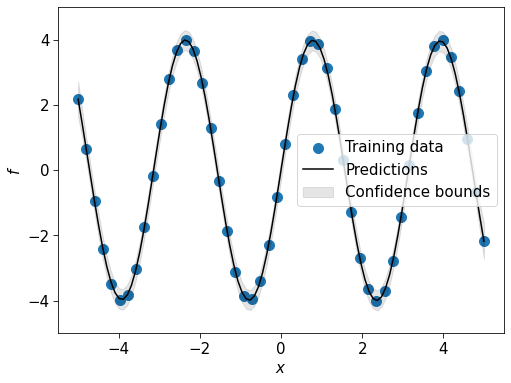

In [10]:
# We will use a bigger dataset of points on a sine curve
X = np.linspace(-5, 5, 50)
y = 4 * np.sin(2 * X)

# kernel = constant kernel * RBF
kernel = ConstantKernel() * RBF()

# Create a GP with this kernel, reducing the measurement noise somewhat
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)

# Print the initial kernel hyperparameters
print("Initial kernel")
print(gp.kernel)

# Fit the GP
gp.fit(X.reshape(-1, 1), y)

# Print the fitted kernel hyperparameters
print("Fitted kernel")
print(gp.kernel_)

# Plot
fig, ax = plt.subplots(figsize=[8, 6])
ax.scatter(X, y)
posterior_means, posterior_stds = gp.predict(X_star, return_std=True)
plot_gp_marginals(X_star, posterior_means, posterior_stds)
plt.legend(["Training data", "Predictions", "Confidence bounds"])

That's it for this notebook. In the lab you will implement a GP in numpy and investigate different kernels for temperature prediction. 


<hr style="border:2px solid black"> </hr>

#### Written by Elliot J. Crowley and &copy; The University of Edinburgh 2022-24